# Lets start off by performing similarity search for images

In [1]:
import numpy as np
import imageio
from skimage import transform
import matplotlib.pyplot as plt
from math import sqrt
import glob
import subprocess

from tqdm import tqdm
import kmeans_gpu
import h5py
import knn_cnn_features

%matplotlib inline

In [2]:
def load_image(img_path, resize=True):
    tmp_img = imageio.imread(img_path)
    if resize:
        return transform.resize(image=tmp_img,output_shape=(200,200),anti_aliasing=True, mode='constant')
    return tmp_img

Let us look at 3 different pictures of golden retriever puppies (Google images found these to be similar)

In [3]:
img1 = load_image("data/images/golden1.jpg")
img2 = load_image("data/images/golden2.jpg")
img3 = load_image("data/images/golden3.jpg")

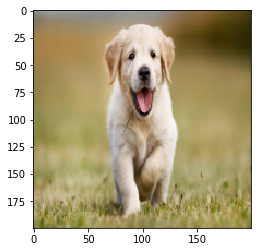

In [4]:
plt.imshow(img1)

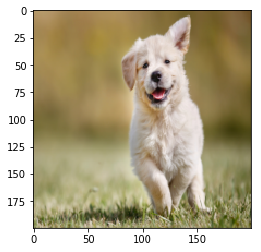

In [5]:
plt.imshow(img2)

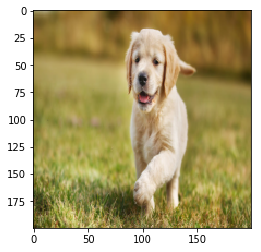

In [6]:
plt.imshow(img3)

In [7]:
def mse_image(image1,image2):
    return sqrt(np.mean((image1-image2)**2))

In [8]:
print(mse_image(img1,img2))
print(mse_image(img2,img3))
print(mse_image(img3,img1))

0.19022686342926862
0.18840959325910303
0.18147532920332463


In [9]:
from skimage.measure import compare_ssim as ssim

In [10]:
print(ssim(img1,img2,multichannel=True))
print(ssim(img2,img3,multichannel=True))
print(ssim(img3,img1,multichannel=True))

0.5622781046149279
0.5310086838617171
0.5215860201451067


We know that `SSIM` (Structural Similarity) is robust to noise and contrast changes unlike `MSE` (Mean Square Error)

In [11]:
# MSE is faster than SSIM
%timeit mse_image(img1,img2)
%timeit ssim(img1,img2,multichannel=True)

133 µs ± 3.56 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
7.44 ms ± 385 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


For the $200\times200$ image, the MSE took 130 $\mu$s while SSIM took 6.68 ms i.e. MSE was $50\times$ faster.

# Dominant color

In [12]:
import dominant_cluster
%timeit dcolors = dominant_cluster.get_dom_colors("data/images/golden1.jpg",clusters=10)

18.3 s ± 2.05 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit dcolors, bar_img = kmeans_gpu.run("data/images/golden1.jpg",clusters=10)
!nvidia-smi

293 ms ± 33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Thu Dec 13 16:57:33 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.48                 Driver Version: 410.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 106...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P2    27W /  N/A |    707MiB /  6078MiB |     33%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:          

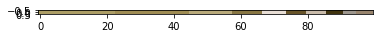

In [14]:
dcolors, bar_img = kmeans_gpu.run("data/images/golden1.jpg",clusters=10)
plt.imshow(bar_img)

We get such a $1\times100$ image for each of the images we cluster i.e. we cluster a resized image of size $200\times200$ and create a smaller image of size $100$ ($0.25\%$) that contains its dominant colors in descending order of dominance. 

The next step is to concatenate these 100 pixel images for each frame (samples at $n$ fps from the video of length $l$ seconds) to create a new image of size $l\times n \times100$ pixel image that will represent the entire video.

This compressed image representation is thereafter used to find similar images using either the **MSE** or **SSIM** similarity metric or by using the **KNN** algorithm.

https://stackoverflow.com/questions/10957412/fastest-way-to-extract-frames-using-ffmpeg

# Vid2Img Representation

In [3]:
!sh extractNFrames.sh data/videos/animals/1.mp4 20

In [19]:
%timeit !ffmpeg -loglevel panic -i data/videos/animals/0.mp4 -vf scale="426x240" -r 1  data/tmp/output_%01d.jpg

181 ms ± 824 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [2]:
# num_of_frames = 20
def cluster_vid(vid_path, num_of_frames=20):
    p = subprocess.Popen("sh extractNFrames.sh "+vid_path+" "+str(num_of_frames), \
                         stdout=subprocess.PIPE, shell=True)
    (output, err) = p.communicate()
    p_status = p.wait()
    frame_list = glob.glob('data/tmp/*.jpg')
    vid_img = None
    for fr in frame_list:
        _, bar_img = kmeans_gpu.run(fr,clusters=10)
        if type(vid_img) is not np.ndarray:
            vid_img = bar_img
        else:
            vid_img = np.concatenate((vid_img, bar_img), axis=0)
    return vid_img

In [18]:
%time vid_img = cluster_vid("data/videos/animals/0.mp4")

CPU times: user 34.6 s, sys: 4.02 s, total: 38.6 s
Wall time: 7.57 s


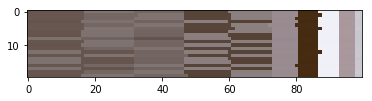

In [29]:
imageio.imwrite("data/vid2img/vid_name.jpg",vid_img)
plt.imshow(vid_img)

In [19]:
classes = sorted([path.split("/")[-1] for path in glob.glob("data/videos/*")])
print(classes)

['animals', 'children', 'christmas', 'nature', 'school', 'snow', 'work']


In [20]:
%%time 
for cl in classes:
    vid_list = sorted(glob.glob('data/videos/'+cl+'/*'))
    for i,vid_path in enumerate(vid_list):
        vid_img = cluster_vid(vid_path)
        imageio.imwrite("data/vid2img/"+cl+"_"+str(i)+".jpg",vid_img)

CPU times: user 40min 42s, sys: 5min 29s, total: 46min 11s
Wall time: 7min 17s


**Thus we see that for $10\times7 = 70$ videos, the process took $437$ seconds to execute i.e. approx $6.2$ seconds for video. This process includes:**
1. **Extracting frames from videos and writing them to disk.**
2. **Clustering the extracted frames (20 per video).**
3. **Converting the histogram of clusters into an image and writing to disk.**

# KNN search using Vid2Img

In [21]:
import knn_vidimg
vid2img_list = sorted(glob.glob('data/vid2img/*.jpg'))

In [22]:
%time vidIndices = knn_vidimg.run_knn_vid2img(vid2img_list,k=3)

Number of records: 70 
Number of dimensions: 6000
Running with Flat index for 70 records of with dimensionality 6000
CPU times: user 42.2 ms, sys: 92.1 ms, total: 134 ms
Wall time: 132 ms


The dimensionality is $6000$ since ($20\times100 = 2000$ pixels and RBG (3) values for each pixel).

The runtime for the KNN search with $k = 3$ (build *and* run on all videos) for this subset of $70$ videos is $132$ms and we can be sure that this will scale effectively based on previous experiments.

*Let us look at the values (for the first video):*

In [23]:
print(vid2img_list[0],":",[vid2img_list[i] for i in vidIndices[0]])

data/vid2img/animals_0.jpg : ['data/vid2img/animals_0.jpg', 'data/vid2img/animals_1.jpg', 'data/vid2img/children_9.jpg']


The videos animals_0.mp4 appears in the results as the closest and this is obvious. The other two videos are a monkey and a cat respectively. It did not care about context - only color.

## Testing with UCF 101 (May not be that good)

In [28]:
videos = sorted(glob.glob("data/UCF101/*"))
ucf_classes = [vid.split('/')[-1].split('_')[1] for vid in videos]
ucf_classes = sorted(list(set(ucf_classes)))

In [4]:
h5f = h5py.File('color_UCF_vid2img.h5', 'w')

In [58]:
# num_of_frames = 8 -> since 8 is median number of frames
def extract_vid2img_serial(videos):
    multi_vid_img = None
    for i, vid in enumerate(videos):
        vid_img = cluster_vid(vid, num_of_frames=8)
        h5f.create_dataset(vid, data=vid_img)
        if type(multi_vid_img) is not np.ndarray:
            multi_vid_img = vid_img[np.newaxis, ...]
        else:
            multi_vid_img = np.concatenate((multi_vid_img, vid_img[np.newaxis, ...]), axis=0)
    return multi_vid_img, videos

In [45]:
%time xx = extract_vid2img(videos[:10])

CPU times: user 2min 15s, sys: 16.9 s, total: 2min 32s
Wall time: 22.9 s


For creating the dominant color based image representation for the video (**serially**), it takes approx $2.3$ seconds per video.

That means $8$ hours for processing the entire UCF101 videos. Lets speed this up.

In [83]:
%%time 
# extracting all frames first
for vid_path in videos:
    p = subprocess.Popen("sh extractNFrames_UCF101.sh "+vid_path+" "+str(8)+" "+\
            vid_path.split('/')[-1].split('.')[0], stdout=subprocess.PIPE, shell=True)
    (output, err) = p.communicate()
    p_status = p.wait()

CPU times: user 4.78 s, sys: 1min 24s, total: 1min 28s
Wall time: 21min 47s


Thats around $0.1$ seconds per video for extracting frames.

In [4]:
def extract_vid2img_parallel(video):
    frame_list = glob.glob('data/tmp/'+video.split('/')[-1].split('.')[0]+'/*.jpg')
    vid_img = None
    for fr in frame_list:
        _, bar_img = kmeans_gpu.run(fr,clusters=10)
        if type(vid_img) is not np.ndarray:
            vid_img = bar_img
        else:
            vid_img = np.concatenate((vid_img, bar_img), axis=0)
    return vid_img, video

In [5]:
# skip those that are already done
skip_vids = glob.glob('data/vid2img/*.npy')
'data/vid2img/'+videos[0].split('/')[-1].split('.')[0]+'.npy' in skip_vids

In [11]:
for vid_path in tqdm(videos):
    if 'data/vid2img/'+vid_path.split('/')[-1].split('.')[0]+'.npy' not in skip_vids:
        vid_img, _ = extract_vid2img_parallel(vid_path)
        np.save('data/vid2img/'+vid_path.split('/')[-1].split('.')[0]+'.npy', vid_img)
    #     h5f[vid_path]=vid_img

100%|██████████| 13320/13320 [9:47:41<00:00,  2.26s/it]  


In [16]:
# ignore for now
import multiprocessing
pool = multiprocessing.Pool(processes=1)
%time vid2img_outputs = pool.map(extract_vid2img_parallel,videos[:10])
pool.close()
pool.join()

CPU times: user 0 ns, sys: 11.8 ms, total: 11.8 ms
Wall time: 21.8 s


In [25]:
np_vid2imgs = sorted(glob.glob('data/vid2img/*.npy'))

In [28]:
color_vid2imgs = np.zeros((len(np_vid2imgs),8*100*3))
for i, np_v in enumerate(np_vid2imgs):
    try:
        color_vid2imgs[i,] = np.load(np_v).flatten().astype('float32')
    except:
        print(np_v)
        continue
#     color_vid2imgs = 

In [35]:
h5f = h5py.File('color_UCF_vid2img.h5', 'w')
h5f['color_vid2imgs'] = color_vid2imgs
h5f['vid_labels'] = np.array([np_v.split('/')[-1].split('.')[0] for np_v in np_vid2imgs], dtype='S')
h5f.close()

In [2]:
h5f = h5py.File('color_UCF_vid2img.h5', 'r')
vid_labels = np.array([fl.decode() for fl in h5f['vid_labels']])
color_vid2imgs = np.array(h5f['color_vid2imgs']).astype('float32')
h5f.close()

In [46]:
%timeit feature_indices = knn_cnn_features.run_knn_features(color_vid2imgs,k=3)

399 ms ± 6.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
%timeit feature_indices = knn_cnn_features.run_knn_features(color_vid2imgs,test_vectors=color_vid2imgs[:10],k=3)

103 ms ± 1.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
def get_cls_accuracy(similar_videos, feature_labels, k=3):
    accuracy = 0
    for i, sim_vids in enumerate(similar_videos):
        true_label = feature_labels[i].split('_')[1]
        for sim_vid in sim_vids:
            pred_label = sim_vid.split('_')[1]
            accuracy += np.sum(pred_label==true_label)/k
    return accuracy/len(feature_labels)

In [69]:
feature_indices = knn_cnn_features.run_knn_features(color_vid2imgs,k=4)
similar_videos = vid_labels[feature_indices]
print("Accuracy:",get_cls_accuracy(similar_videos,vid_labels))

Accuracy: 0.5690690690688871


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(color_vid2imgs, vid_labels, \
                                        test_size=0.3, random_state=42)

In [5]:
feature_indices = knn_cnn_features.run_knn_features(X_train,test_vectors=X_test,k=3)

In [8]:
similar_videos = y_train[feature_indices]
print("Accuracy:",get_cls_accuracy(similar_videos,y_test))

Accuracy: 0.20545545545546132


In [10]:
similar_videos_flat = [item.split('_')[1] for sublist in similar_videos for item in sublist]
y_test_flat = [item.split('_')[1] for item in y_test for i in range(3)]

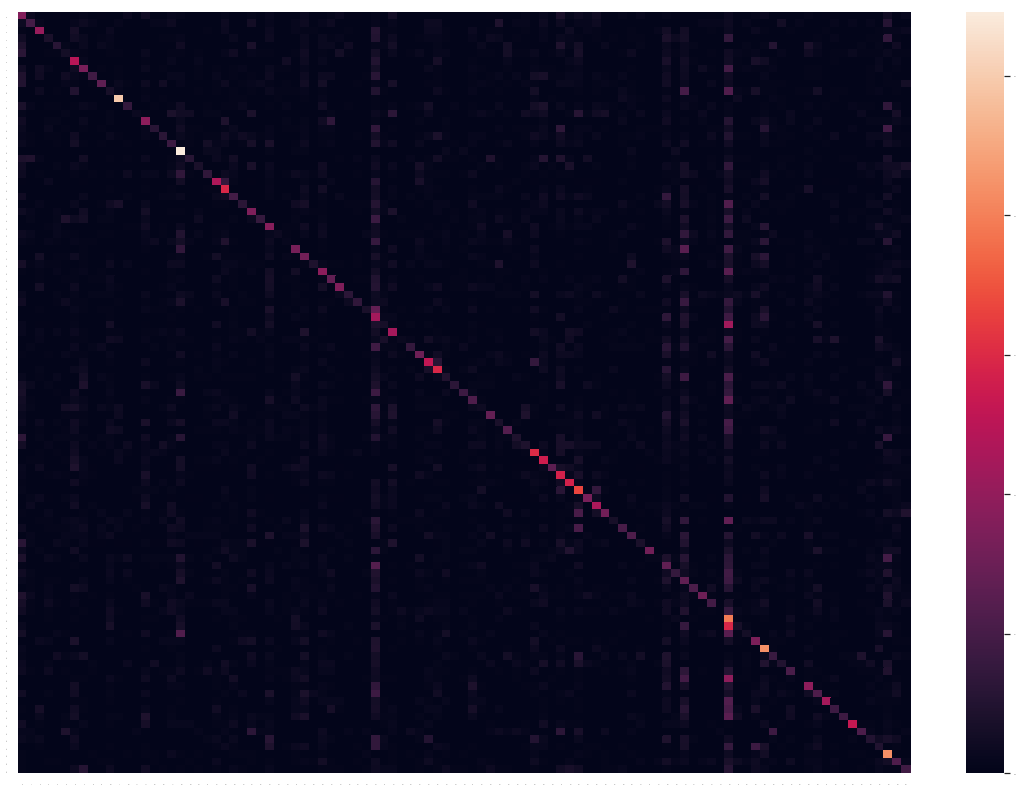

In [11]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test_flat, similar_videos_flat)
cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cnf_matrix, range(101),
                  range(101))
plt.figure(figsize = (20,14))
sn.set(font_scale=0.1)#for label size
sn.heatmap(df_cm, annot=False)# font size ,annot_kws={"size": 16}

In [32]:
notsogood = []
for i, row in enumerate(cnf_matrix):
    for j, colj in enumerate(row):
        if colj > 0.25 and i!=j:
            print(cnf_matrix[i,j])
            notsogood.append([i,j])
for nsgi in notsogood:
    print(ucf_classes[nsgi[1]],"->",ucf_classes[nsgi[0]])

0.3270440251572327
0.4411764705882353
0.29365079365079366
Skiing -> HorseRiding
Skiing -> Skijet
Skiing -> Swing


In [37]:
for i, row in enumerate(cnf_matrix):
    for j, colj in enumerate(row):
        if colj > 0.8 and i==j:
            print(cnf_matrix[i,j],i,j)

0.8181818181818182 18 18


In [38]:
ucf_classes[18]

'BreastStroke'